기존 코드는 텐서플로우 버전 1.xx에서 작동하는 코드로, 버전 2.xx에서는 작동에 어려움이 있었기에, <br>
텐서플로우 버전 2.xx에서 작동할 수 있도록 오류가 발생하는 부분에서 코드 수정

In [1]:
# 필요한 라이브러리 부름
import tensorflow as tf
import numpy as np
import np_utils 
import matplotlib.pyplot as plt

In [2]:
# 재현성을 위해 시드 지정: TensorFlow 2.x에서는 tf.random.set_seed(seed) 사용
tf.random.set_seed(0)

In [3]:
# 매개변수 지정
# 학습률: 0.1
# 반복 수: 10000
# 임베딩 차원: 2
# 윈도우 크기: 1
learning_rate=0.1
nepochs=10000
embedding_dim=2
window_size = 1

In [4]:
# 워드 임베딩에 적용할 문장
#text = 'Arthur is a famous king He is a brave man The king is royal Elizabeth is the royal  queen She is a beautiful woman'
text ="King is a brave man Queen is a beautiful woman"

# 소문자로 변환
text = text.lower()

# 간단한 불용어와 문자 그리고 숫자 제거
word_seq = []
for word in text.split():
    if ((word != '.') & (word not in '0123456789')& (word not in ['a','is', 'the'] )):
        word_seq.append(word)
        
# 고유한 단어들로 만든 집합
unique_words = set(word_seq) 
n_unique_words = len(unique_words) 

# 단어와 정수 매핑
word_to_int = {w: i for i, w in enumerate(unique_words)}
int_to_word = {i: w for i, w in enumerate(unique_words)}

In [5]:
# 훈련에 사용될 데이터 [input, target] 만듬              
data = []
for i in range(1, len(word_seq) - 1):
    # [input, target] = [neighbors, target]
    target = word_seq[i]
    neighbor=[]
    for j in range(window_size):
        neighbor.append(word_seq[i - j-1])
        neighbor.append(word_seq[i +  j+ 1])

    for w in neighbor:
        data.append([w, target])

In [34]:
# 원-핫 벡터로 변환
from keras.utils import to_categorical  # 모듈 추가
x_train = [] 
y_train = [] 

for w in data:
    # 기존 코드 수정: np_utils.to_categorical -> to_categorical
    x_train.append(to_categorical(word_to_int[w[0]] , n_unique_words)) 
    y_train.append(to_categorical(word_to_int[w[1]] , n_unique_words))
    
# 넘파이 arrary로 변환
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# 훈련에 사용될 placeholder
# 기존 코드 수정: placeholder 대신 tf.keras.Input 사용
X = tf.keras.Input(shape=(n_unique_words,), dtype=tf.float32)
Y = tf.keras.Input(shape=(n_unique_words,), dtype=tf.float32)

# 입력층과 은닉층의 가중치
# 기존 코드 수정: tf.random_normal -> tf.random.normal
W1 = tf.Variable(tf.random.normal([n_unique_words, embedding_dim]))
b1 = tf.Variable(tf.random.normal([embedding_dim]))

# 은닉층 값 (Dense 층 사용)
# tf.keras.Input은 TensorFlow 연산에 직접 사용하면 안됨
hidden_representation = tf.keras.layers.Dense(embedding_dim, activation='relu')(X)
# 은닉층과 출력층의 가중치: 기존 코드 수정(tf.random_normal -> tf.random.normal)
W2 = tf.Variable(tf.random.normal([embedding_dim, n_unique_words]))
b2 = tf.Variable(tf.random.normal([n_unique_words]))

# 출력층 값 계산 (Softmax 레이어 사용)
output_layer_logits = tf.keras.layers.Dense(n_unique_words)(hidden_representation)
prediction = tf.keras.layers.Softmax()(output_layer_logits)

# 손실함수: 위키독스 "토닥토닥 파이썬 - 딥러닝 (텐서플로우 v2)" 참고 
def categorical_crossentropy(Y, predictions):
    cross_entropy = tf.reduce_sum(Y * (-tf.math.log(prediction)), axis=1) 
    cross_entropy_loss = tf.reduce_mean(cross_entropy)
    return cross_entropy_loss

# optimizer 정의
optimizer = tf.keras.optimizers.SGD(learning_rate)

In [36]:
#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
losses = []
for epoch in range(nepochs):
    with tf.GradientTape() as tape:
        hidden_representation = tf.add(tf.matmul(x_train, W1), b1)
        prediction = tf.nn.softmax(tf.add(tf.matmul(hidden_representation, W2), b2))
        loss = tf.reduce_mean(-tf.reduce_sum(y_train * tf.math.log(prediction), axis=1))
    
    gradients = tape.gradient(loss, [W1, b1, W2, b2])
    optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2]))
    
    losses.append(loss)
    
    if epoch % 100 == 0:
        print('Epoch={}, Loss={}'.format(epoch, loss))

Epoch=0, Loss=2.240368366241455
Epoch=100, Loss=0.5861372947692871
Epoch=200, Loss=0.42659276723861694
Epoch=300, Loss=0.3855101466178894
Epoch=400, Loss=0.37079355120658875
Epoch=500, Loss=0.3637145161628723
Epoch=600, Loss=0.35965970158576965
Epoch=700, Loss=0.35706788301467896
Epoch=800, Loss=0.3552834093570709
Epoch=900, Loss=0.35398733615875244
Epoch=1000, Loss=0.3530072271823883
Epoch=1100, Loss=0.35224252939224243
Epoch=1200, Loss=0.3516307473182678
Epoch=1300, Loss=0.3511311113834381
Epoch=1400, Loss=0.3507160544395447
Epoch=1500, Loss=0.3503662347793579
Epoch=1600, Loss=0.35006773471832275
Epoch=1700, Loss=0.34981024265289307
Epoch=1800, Loss=0.3495860993862152
Epoch=1900, Loss=0.3493892550468445
Epoch=2000, Loss=0.34921514987945557
Epoch=2100, Loss=0.34906017780303955
Epoch=2200, Loss=0.3489214777946472
Epoch=2300, Loss=0.3487965166568756
Epoch=2400, Loss=0.3486834764480591
Epoch=2500, Loss=0.3485807776451111
Epoch=2600, Loss=0.3484870493412018
Epoch=2700, Loss=0.348401248455

Text(0, 0.5, 'Losses')

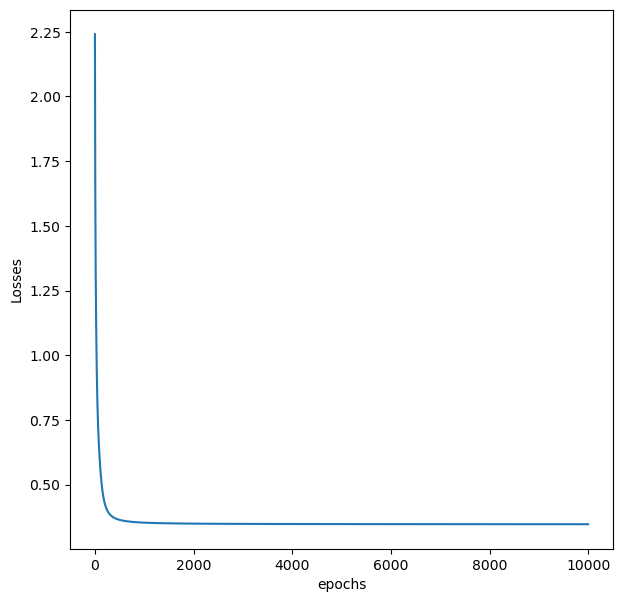

In [37]:
# 훈련과정의 loss 그림      
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses)
ax.set_xlabel('epochs')
ax.set_ylabel('Losses')

In [38]:
# 임베딩 결과
vectors = W1 + b1.numpy()
print(vectors)

tf.Tensor(
[[ 2.4366765 -1.0422685]
 [ 1.4779142  2.916952 ]
 [-2.0306478  1.7680478]
 [ 2.4744697  1.065182 ]
 [-2.2060013 -0.2802062]
 [-1.3303946 -2.2005389]], shape=(6, 2), dtype=float32)


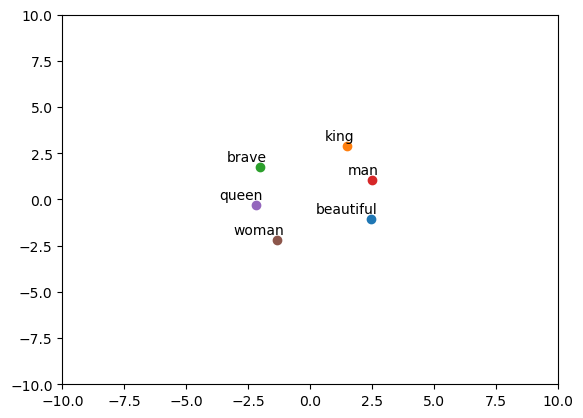

In [43]:
# 임베딩 그래프
fig, ax = plt.subplots()
for i, label in enumerate(word_to_int):
    x, y = vectors[i]
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.show()